# Geographical scope

This notebook pulls in the census tract information for Brooklyn, which can be used to perform analyses specifically on Red Hook and the project site.

In [1]:
# Libraries
import pandas as pd
import geopandas as gpd
import shapely
from shapely.geometry import Polygon
from fiona.crs import from_epsg
import matplotlib.pylab as plt
import urllib.request
import copy
from IPython.display import Image

## Polygons of NYC census tracts

In [2]:
# Uncomment the following to rerun in case files are somehow deleted:
# url = 'https://data.cityofnewyork.us/api/geospatial/fxpq-c8ku?method=export&format=Shapefile'
# urllib.request.urlretrieve(url, 'census_tracts.gz')
# !mkdir data/primary_source_data/census_tracts
# !unzip census_tracts.gz -d data/primary_source_data/census_tracts
# !rm -r census_tracts.gz

In [3]:
# Census shapefile contents
files = !ls data/primary_source_data/census_tracts
print(list(enumerate(files)))

[(0, 'geo_export_a1169309-1083-403c-8f43-77f62e2a399e.dbf'), (1, 'geo_export_a1169309-1083-403c-8f43-77f62e2a399e.prj'), (2, 'geo_export_a1169309-1083-403c-8f43-77f62e2a399e.shp'), (3, 'geo_export_a1169309-1083-403c-8f43-77f62e2a399e.shx')]


In [4]:
# Census tracts for all of NYC
shp = files[2]
loc = 'data/primary_source_data/census_tracts/' + shp
cen_tracts = gpd.GeoDataFrame.from_file(loc)
cen_tracts.rename(columns={'puma':'GeoID'}, inplace=True)
cen_tracts['GeoID'] = cen_tracts['GeoID'].astype('int')
cen_tracts.to_crs(epsg=2263, inplace = True)
cen_tracts.head()

,boro_code,boro_ct201,boro_name,cdeligibil,ct2010,ctlabel,ntacode,ntaname,GeoID,shape_area,shape_leng,geometry
0,5,5000900,Staten Island,I,000900,9,SI22,West New Brighton-New Brighton-St. George,3903,2.497010e+06,7729.016794,"POLYGON ((962269.1260375973 173705.5001830519,..."
1,1,1009800,Manhattan,I,009800,98,MN19,Turtle Bay-East Midtown,3808,1.906016e+06,5534.199811,"POLYGON ((994133.5070190424 214848.8975829605,..."
2,1,1010000,Manhattan,I,010000,100,MN19,Turtle Bay-East Midtown,3808,1.860938e+06,5692.168737,"POLYGON ((993108.3057861348 216013.1307982849,..."
3,1,1010200,Manhattan,I,010200,102,MN17,Midtown-Midtown South,3807,1.860993e+06,5687.802439,"POLYGON ((992216.5391845678 216507.687011669, ..."
4,1,1010400,Manhattan,I,010400,104,MN17,Midtown-Midtown South,3807,1.864600e+06,5693.036367,"POLYGON ((991325.8815917961 217001.6885985838,..."


## Red Hook tracts

In [5]:
# Filter down to Red Hook only
red_hook_tracts = cen_tracts[cen_tracts['ntaname']=='Carroll Gardens-Columbia Street-Red Hook']

In [6]:
"""
ctlabel values are based on a combination of Google Maps research and labels provided by NYC DCP:
https://data.cityofnewyork.us/City-Government/2010-Census-Tracts/fxpq-c8ku
"""
red_hook_tracts = red_hook_tracts[(red_hook_tracts['ctlabel']=='53') | (red_hook_tracts['ctlabel']=='59') | \
                                  (red_hook_tracts['ctlabel']=='85')]

In [7]:
red_hook_tracts

,boro_code,boro_ct201,boro_name,cdeligibil,ct2010,ctlabel,ntacode,ntaname,GeoID,shape_area,shape_leng,geometry
1053,3,3008500,Brooklyn,E,008500,85,BK33,Carroll Gardens-Columbia Street-Red Hook,4005,2.624914e+06,7950.931705,"POLYGON ((983874.1970214838 185474.7022094189,..."
2144,3,3005300,Brooklyn,I,005300,53,BK33,Carroll Gardens-Columbia Street-Red Hook,4005,1.769598e+07,55170.029926,"POLYGON ((982904.2286376971 189083.8547973089,..."
2146,3,3005900,Brooklyn,I,005900,59,BK33,Carroll Gardens-Columbia Street-Red Hook,4005,3.852116e+06,10119.007515,"POLYGON ((982636.036804201 188350.9956054121, ..."


## Centroids of NYC and Red Hook census tracts

In [8]:
# Centroids for all NYC tracts
cen_tracts_centroids = copy.deepcopy(cen_tracts)

In [9]:
cen_tracts_centroids['geometry'] = cen_tracts_centroids['geometry'].centroid
cen_tracts_centroids.reset_index(drop=True, inplace=True)

In [10]:
# Centroids for Red Hook tracts
red_hook_centroids = cen_tracts_centroids[cen_tracts_centroids['ntaname']=='Carroll Gardens-Columbia ' + \
                                          'Street-Red Hook']
red_hook_centroids = red_hook_centroids[(red_hook_centroids['ctlabel']=='53') | \
                                (red_hook_centroids['ctlabel']=='59') | (red_hook_centroids['ctlabel']=='85')]

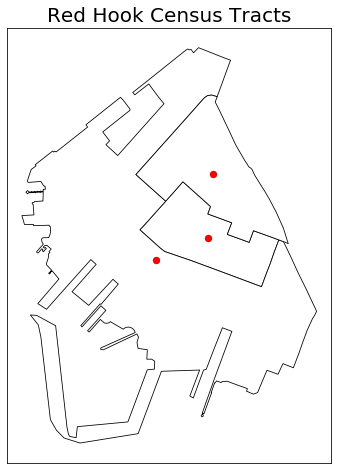

In [11]:
# Red Hook tracts with centroids of each tract
f, ax = plt.subplots(figsize=(8,8))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
red_hook_tracts.plot(alpha=1,linewidth=0.8,ax=ax,color='w',edgecolor='black')
red_hook_centroids.plot(alpha=1, linewidth=0.2,ax=ax,color='r',edgecolor='black',markersize=50)
plt.title("Red Hook Census Tracts", fontsize=20)
plt.show()

## Combining Red Hook tracts

In [12]:
# Combined
rh_comb_tract = red_hook_tracts.dissolve(by='ntaname')

In [13]:
# rh_comb_tract.to_file('data/created_data/rh_comb_tract/rh_comb_tract.shp', driver='ESRI Shapefile')

In [14]:
# Finding the center of the combined census tracts
rh_comb_center = copy.deepcopy(rh_comb_tract)
rh_comb_center['geometry'] = rh_comb_center['geometry'].centroid
rh_comb_center.reset_index(drop=True, inplace=True)

In [15]:
rh_comb_center

,geometry,boro_code,boro_ct201,boro_name,cdeligibil,ct2010,ctlabel,ntacode,GeoID,shape_area,shape_leng
0,POINT (981704.128458995 185397.0757719122),3,3008500,Brooklyn,E,008500,85,BK33,4005,2.624914e+06,7950.931705


In [16]:
# rh_comb_center.to_file("data/created_data/rh_centroid/rh_centroid.shp")

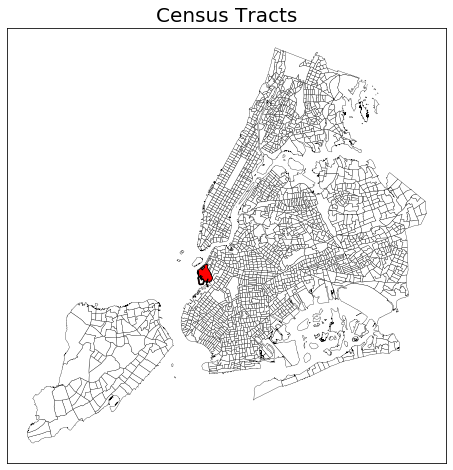

In [17]:
# Red Hook with 1 center
f, ax = plt.subplots(figsize=(12,8))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
cen_tracts.plot(alpha=1,linewidth=0.3,ax=ax,color='w',edgecolor='black')
rh_comb_tract.plot(alpha=1,linewidth=0.8,ax=ax,color='r', facecolor='r', edgecolor='black')
plt.title("Census Tracts", fontsize=20)
plt.show()

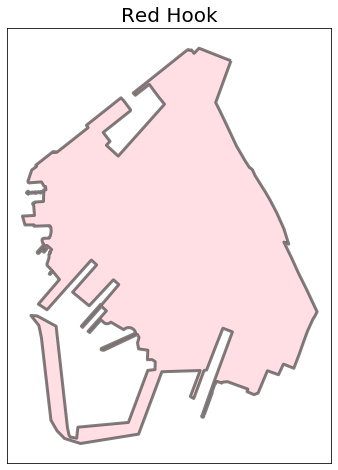

In [18]:
# Red Hook with 1 center
f, ax = plt.subplots(figsize=(12,8))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
rh_comb_tract.plot(alpha=.5,linewidth=3,ax=ax,color='pink',edgecolor='black')
plt.title("Red Hook", fontsize=20)
plt.show()

## Buffer for Red Hook

In [19]:
# Set the buffer radius for all of Red Hook in miles here:
# rh_buffer_radius = .25
rh_buffer_radius = 1000

In [20]:
rh_buffer = copy.deepcopy(rh_comb_center)

In [21]:
# Old way
# rh_buffer['geometry'] = rh_buffer['geometry'].buffer(rh_buffer_radius*(1/60))
rh_buffer['geometry'] = rh_buffer['geometry'].buffer(rh_buffer_radius)
rh_buffer.reset_index(drop=True, inplace=True)
rh_buffer

,geometry,boro_code,boro_ct201,boro_name,cdeligibil,ct2010,ctlabel,ntacode,GeoID,shape_area,shape_leng
0,"POLYGON ((982704.128458995 185397.0757719122, ...",3,3008500,Brooklyn,E,008500,85,BK33,4005,2.624914e+06,7950.931705


In [22]:
# rh_buffer.to_file('data/created_data/rh_centroid_buffer/rh_centroid_buffer.shp', driver='ESRI Shapefile')

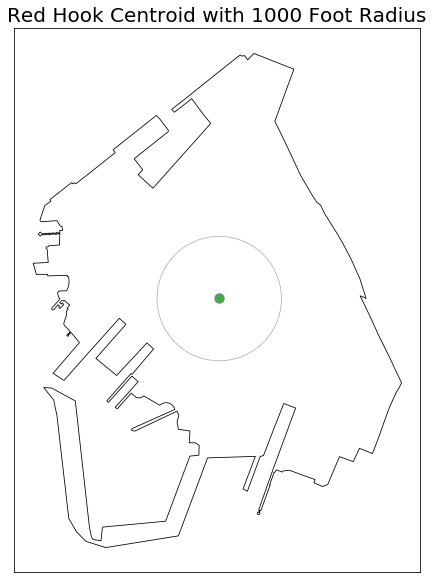

In [23]:
# Red Hook with buffer radius
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
rh_comb_tract.plot(alpha=1,linewidth=0.8,ax=ax,color='w',edgecolor='black')
rh_comb_center.plot(alpha=1, linewidth=0.2,ax=ax,color='g',edgecolor='black',markersize=100)
rh_buffer.plot(alpha=.3,linewidth=0.8,ax=ax,color='w',edgecolor='black')
plt.title("Red Hook Centroid with {} Foot Radius".format(rh_buffer_radius), fontsize=20)
plt.show()

# Project site

An approximate geographical basis for the project site can be created using the four points at each intersection that form the four corners of the project site. Here's a screenshot from Google Maps of the four intersections that were used:

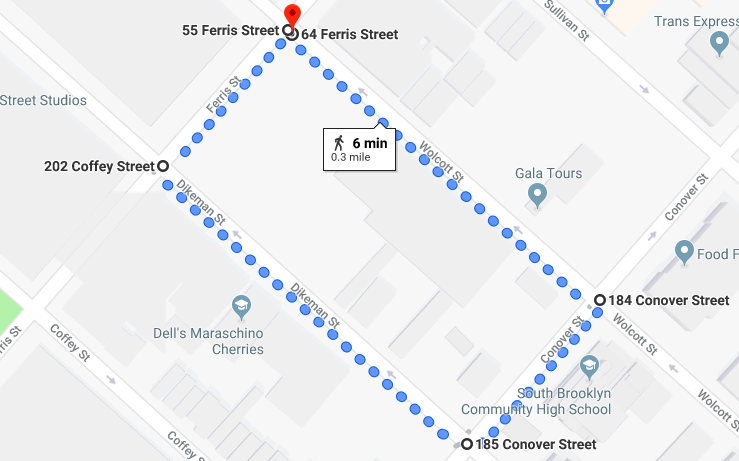

In [24]:
Image('data/created_data/site_outline.png')

Using the latitude and longitude data for each of the four points, we can then find the centroid of the site and create a buffer from there. Note that the location data below is entered in longitude, latitude format for geospatial manipulations.

## Project site points and polygon

In [25]:
site_loc_dict = {'north': (-74.015678, 40.679190), 'south': (-74.014761, 40.677629),\
            'east': (-74.014149, 40.678158), 'west': (-74.016279, 40.678654)}
site_lats = [40.679190, 40.678158, 40.677629, 40.678654]
site_lons = [-74.015678, -74.014149, -74.014761, -74.016279]

In [26]:
# Create a polygon for the project site
site_poly_geom = Polygon(zip(site_lons, site_lats))
crs = {'init': 'epsg:4326'}
site_poly = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[site_poly_geom])
site_poly.to_crs(epsg=2263, inplace = True)

In [27]:
# Create a dataframe from the project site corners
site_points = pd.DataFrame.from_dict(site_loc_dict, orient='index', columns = ['lon', 'lat'])
site_points.reset_index(inplace=True)
site_points.rename(columns={'index':'dir'}, inplace=True)
site_points

,dir,lon,lat
0,north,-74.015678,40.679190
1,south,-74.014761,40.677629
2,east,-74.014149,40.678158
3,west,-74.016279,40.678654


In [28]:
# Turn that df into a gdf
site_points['lonlat'] = list(zip(site_points.lon, site_points.lat))
site_points['geometry'] = site_points[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
site_points_gdf = gpd.GeoDataFrame(site_points)
site_points_gdf.crs = from_epsg(4326)
site_points_gdf.to_crs(epsg=2263, inplace = True)
site_points_gdf.drop(['lonlat'], axis=1, inplace=True)

In [29]:
site_points_gdf

,dir,lon,lat,geometry
0,north,-74.015678,40.679190,POINT (979901.4342458325 186724.0361720367)
1,south,-74.014761,40.677629,POINT (980155.6842946138 186155.2748011244)
2,east,-74.014149,40.678158,POINT (980325.4682323538 186347.9766863181)
3,west,-74.016279,40.678654,POINT (979734.700162744 186528.7863572179)


## Project site centroid and buffer

In [30]:
# Set the buffer radius for the project site in miles here:
# site_buffer_radius = .25
site_buffer_radius = 1000

In [31]:
# Site centroid
site_centroid = copy.deepcopy(site_poly)

In [32]:
site_centroid['geometry'] = site_centroid['geometry'].centroid
site_centroid.reset_index(drop=True, inplace=True)

In [33]:
# Exporting data
# site_points_gdf.to_file('data/created_data/site/site_points/site_points.shp')
# site_centroid.to_file('data/created_data/site/site_centroid/site_centroid.shp')
# site_poly.to_file('data/created_data/site/site_poly/site_poly.shp')

In [34]:
# Site buffer
site_buffer = copy.deepcopy(site_centroid)

In [35]:
# site_buffer['geometry'] = site_buffer['geometry'].buffer(site_buffer_radius*(1/60))
site_buffer['geometry'] = site_buffer['geometry'].buffer(site_buffer_radius)
site_buffer.reset_index(drop=True, inplace=True)

In [36]:
# site_buffer.to_file('data/created_data/site/site_centroid_buffer/site_centroid_buffer.shp')

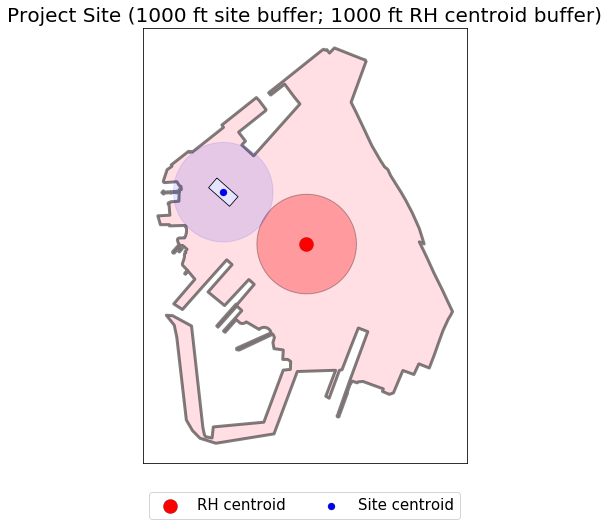

In [37]:
# Red Hook centroid in red with buffer and site in blue with buffer
f, ax = plt.subplots(figsize=(8,8))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
# Red Hook combined census tracts with centroid and buffer
rh_comb_tract.plot(alpha=.5,linewidth=3,ax=ax,color='pink',edgecolor='black')
rh_comb_center.plot(alpha=1, linewidth=0.2,ax=ax,color='r',edgecolor='black',markersize=200, label='RH centroid')
rh_buffer.plot(alpha=.3,linewidth=1,ax=ax,color='r',edgecolor='black')
# Site block with centroid and buffer
site_poly.plot(alpha=1,linewidth=0.8,ax=ax,color='w',edgecolor='black')
site_centroid.plot(alpha=1, linewidth=0.2,ax=ax,color='b',edgecolor='black',markersize=50, label='Site centroid')
site_buffer.plot(alpha=.1,linewidth=1,ax=ax,color='b',edgecolor='b')
# Show plot
plt.title("Project Site ({} ft site buffer; {} ft RH centroid buffer)"\
          .format(site_buffer_radius, rh_buffer_radius), fontsize=20)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),ncol=5,fontsize=15)
plt.show()

# To do:

Make sure that the right way to make buffer is with raw number of feet

## Site with only 400 foot buffer

In [43]:
site_buffer_radius = 400

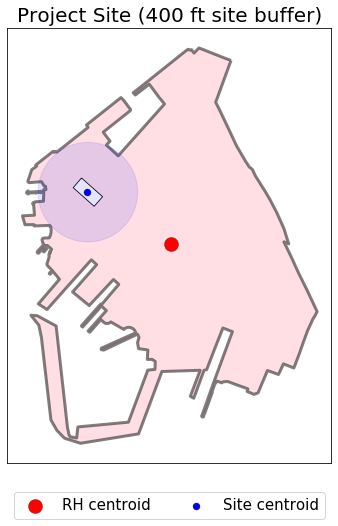

In [45]:
# Red Hook centroid in red with buffer and site in blue with buffer
f, ax = plt.subplots(figsize=(8,8))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
# Red Hook combined census tracts with centroid and buffer
rh_comb_tract.plot(alpha=.5,linewidth=3,ax=ax,color='pink',edgecolor='black')
rh_comb_center.plot(alpha=1, linewidth=0.2,ax=ax,color='r',edgecolor='black',markersize=200, label='RH centroid')
# Site block with centroid and buffer
site_poly.plot(alpha=1,linewidth=0.8,ax=ax,color='w',edgecolor='black')
site_centroid.plot(alpha=1, linewidth=0.2,ax=ax,color='b',edgecolor='black',markersize=50, label='Site centroid')
site_buffer.plot(alpha=.1,linewidth=1,ax=ax,color='b',edgecolor='b')
# Show plot
plt.title("Project Site ({} ft site buffer)"\
          .format(site_buffer_radius), fontsize=20)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),ncol=5,fontsize=15)
plt.show()